In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Gesture Recognition Training 

In [2]:
import s3fs
import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
import json
import random
import os
import random
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [3]:
# Redundent Random seed setting to ensure reproducible results  
random.seed(314)
np.random.seed(314)
tf.set_random_seed(314)

In [4]:
def read_data_into_dataframe(fs,gesture_paths):
    
    examples = []
    for file in gesture_paths:
        with fs.open(file) as f:
            opened_file = json.loads(f.read())
        
        examples.append(opened_file)
    
    examples = pd.io.json.json_normalize(examples)
    
    return examples 

In [5]:
path_to_data = "cchase-rh-demo-4/training-data"
fs = s3fs.S3FileSystem()
list_of_gesture_paths = fs.walk(path_to_data)
then = time.time()
Data = read_data_into_dataframe(fs,list_of_gesture_paths)
print((time.time()-then)/60,"minutes")
print(len(Data), "records read...")

1.9914133906364442 minutes
849 records read...


In [6]:
def get_acceleration_data(df):
    re_arranged = []

    for row_index in range(len(Data)):

        x = [i[0] for i in df.iloc[row_index].motion]
        y = [i[1] for i in df.iloc[row_index].motion]
        z = [i[2] for i in df.iloc[row_index].motion]
        gesture = df.iloc[row_index].gesture

        entry = [x,y,z,gesture]
        re_arranged.append(entry)

    return pd.DataFrame(re_arranged, columns=["x","y","z","gesture"])
    

In [7]:
Acceleration_Data =  get_acceleration_data(Data)

In [8]:
def featurize(df_row, bins, columns):
    

    dimension_names = columns
    features = {}
    
    for ts, dim in zip(df_row,dimension_names):
        
        mean = np.mean(ts)
        median = np.median(ts)
        std = np.std(ts)
        length = len(ts)
        kurtosis = scipy.stats.kurtosis(ts)

        n, b = np.histogram(ts, 10)
        n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin

        if median == 0: 
            features[f'{dim}_mean_over_median'] =  0 #dimensionless            
            features[f'{dim}_std_over_median'] =  0 #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition
    

        else: 
            features[f'{dim}_mean_over_median'] =  mean/median #dimensionless            
            features[f'{dim}_std_over_median'] = std/median #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition


        for i, val in enumerate(n):
            features[f'{dim}_binfrac_{i}'] = val


        # new feature:
        midpoint = length//2
        ts_before = ts[:midpoint]
        ts_after = ts[midpoint:]

        mean_before = np.mean(ts_before) 
        mean_after = np.mean(ts_after)

        features[f'{dim}_mean_over_median_before'] = mean_before/median
        features[f'{dim}_mean_over_median_after'] = mean_after/median

        if length > 10:
            amp = np.fft.fft(ts)
            freq = np.fft.fftfreq(amp.size, 0.16)
            a_p = abs(amp.real[:1+len(amp)//2])
            f_p = freq[:1+len(freq)//2]

            max_power_index = np.argmax(abs(a_p[3:]))+3
            features[f'{dim}_max_power'] = abs(a_p[max_power_index])
            features[f'{dim}_period'] = f_p[max_power_index]
        else:
            features[f'{dim}_max_power'] = 0
            features[f'{dim}_period'] = 0


    features['label'] = df_row.gesture

    return features

In [9]:
then = time.time()
examples = [] 
b = np.arange(1,100,10)
columns = ["x","y","z"]
for i in Acceleration_Data.index:
    example = featurize(Acceleration_Data.iloc[i], b,columns)
    examples.append(example)
    
print((time.time()-then)/60,"minutes")
    

0.026206604639689126 minutes


In [10]:
df = pd.DataFrame(examples)

In [11]:
df = df[df["x_length"] > 200]
df = df.dropna()

In [12]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (598, 55)
test size = (200, 55)
roll             114
draw-circle      103
draw-triangle    102
shake            100
fever             93
floss             86
Name: label, dtype: int64
shake            41
fever            37
draw-triangle    34
roll             32
floss            29
draw-circle      27
Name: label, dtype: int64


In [13]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [14]:
model_1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

In [15]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model_1.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [16]:
history = model_1.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, verbose=1)

Epoch 1/5000
598/598 [==============================] - 0s 192us/step - loss: 285.6449 - acc: 0.1605
Epoch 2/5000
598/598 [==============================] - 0s 24us/step - loss: 152.9069 - acc: 0.1488
Epoch 3/5000
598/598 [==============================] - 0s 24us/step - loss: 70.9395 - acc: 0.2341
Epoch 4/5000
598/598 [==============================] - 0s 25us/step - loss: 41.3944 - acc: 0.3177
Epoch 5/5000
598/598 [==============================] - 0s 27us/step - loss: 29.9481 - acc: 0.3528
Epoch 6/5000
598/598 [==============================] - 0s 26us/step - loss: 22.5175 - acc: 0.3829
Epoch 7/5000
598/598 [==============================] - 0s 26us/step - loss: 17.3561 - acc: 0.4047
Epoch 8/5000
598/598 [==============================] - 0s 26us/step - loss: 13.4078 - acc: 0.4247
Epoch 9/5000
598/598 [==============================] - 0s 25us/step - loss: 11.6222 - acc: 0.4097
Epoch 10/5000
.......Epoch 4999/5000
598/598 [==============================] - 0s 31us/step - loss: 0.154

In [17]:
output_notebook()
p = figure()
p.line(np.linspace(1,5000,5000),history.history['acc'])
show(p)

Loading BokehJS ...

In [18]:
test_loss, test_acc = model_1.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

200/200 [==============================] - 0s 221us/step
Test accuracy: 0.62


Text(0, 0.5, 'predicted')

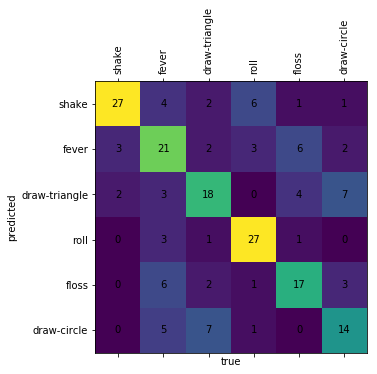

In [19]:
y_hat = model_1.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [20]:
print(classification_report(test_label, y_hat, labels=labels))

               precision    recall  f1-score   support

        shake       0.84      0.66      0.74        41
        fever       0.50      0.57      0.53        37
draw-triangle       0.56      0.53      0.55        34
         roll       0.71      0.84      0.77        32
        floss       0.59      0.59      0.59        29
  draw-circle       0.52      0.52      0.52        27

    micro avg       0.62      0.62      0.62       200
    macro avg       0.62      0.62      0.62       200
 weighted avg       0.63      0.62      0.62       200



In [21]:
test_set = test_df.drop('label', axis=1)
y = test_df.label.values

In [22]:
def confident_evaluation(X,y,model,label_encoder, threshold):
    
    feature_vectors = X.values 
    probabilities = model.predict_proba(feature_vectors)
    probabilities = pd.DataFrame(np.exp(probabilities))
    
    max_probability = pd.Series(np.max(probabilities, axis=1))
    gesture = probabilities.idxmax(axis=1)
    confident = pd.Series(max_probability >= threshold)
    
    accuracy = []
    unkown = []
    
    for prediction in confident.index:
        
        if confident[prediction] == True:
            predicted_gesture = label_encoder.inverse_transform([gesture[prediction]])[0]
            if predicted_gesture == y[prediction]:
                accuracy.append(1)
            else:
                accuracy.append(0)

        else:
            unkown.append(1)
        

    print("\nNumber of confident gestures: ", len(accuracy))
    
    print("Confident accuracy: ", float(sum(accuracy))/len(accuracy))
    
    print("Number of unknown gestures: ", len(unkown))
    
    print("Model was not confident about", len(unkown)/len(y)*100, "percent of data")
        

In [23]:
confident_evaluation(test_df.drop('label',axis=1), y, model_1 ,label_encoder, 0.85)


Number of confident gestures:  144
Confident accuracy:  0.6944444444444444
Number of unknown gestures:  56
Model was not confident about 28.000000000000004 percent of data


In [24]:
# Save model for serving

In [25]:
import os
from pathlib import Path
from datetime import datetime as dt

save = False
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"models/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}